In [33]:
! pip install fbprophet --quiet
! pip install statsmodels==0.12.1 --quiet
! pip install neuralprophet --quiet
! pip install nbeats-forecast --quiet
! pip install tbats --quiet

In [59]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
from neuralprophet import NeuralProphet
from tbats import TBATS, BATS
from nbeats_forecast import NBeats
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
uploaded = files.upload()

Saving Lions_Den_data.xlsx to Lions_Den_data.xlsx


In [4]:
DATA_PATH = 'Lions_Den_data.xlsx'
DATE_COLUMN = 'DATE'

Read data

In [5]:
df = pd.read_excel(DATA_PATH, index_col=0, parse_dates=True)

Plot series

<Figure size 432x288 with 0 Axes>

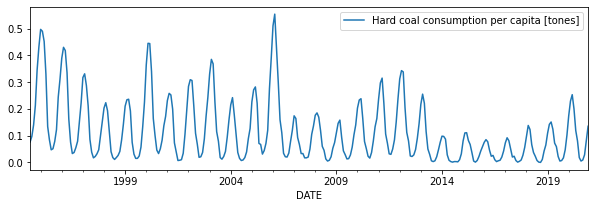

In [6]:
plt.figure(); df.plot(figsize=(10,3)); plt.legend(loc='best')

<h1>MODELS</h1>

<b> models </b><br>

Simple models: ETS, SARIMAX

bayesian models: Prophet, Neural Prophet

advanced DL: n-beats

advanced classic: tbeats

<b>evaluation method:</b><br>

Rolling window on val set for choosing best hyperparameters (if hyperparameters are optimized), final metrics results will be reported on test set (last n observations), final model for future prediction will be trained on all observations


<b>metrics:</b> 

RMSE, MAE, MAPE, SMAPE, $R^2$

In [68]:
def plot_prediction(train, val, preds):
    prediction = pd.DataFrame()
    prediction['real'] = pd.concat([train, val])['y'].values
    prediction['yhat'] = np.concatenate((train['y'].values, np.squeeze(preds)), axis=0)
    plt.figure(figsize=(10,3)) 
    plt.plot(range(prediction.shape[0]), prediction['real'].values, label='real')
    plt.plot(range(train.shape[0] ,preds.shape[0] + train.shape[0]), preds, label='yhat')
    plt.legend(loc='best')

def rolling_prediction():
    return 0

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 0.01))) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (0.01 + np.abs(y_true) + np.abs(y_pred)))

def evaluate(y_true, y_pred):
    scores = {}
    scores['mae'] = mean_absolute_error(y_true, y_pred)
    scores['mse'] = mean_squared_error(y_true, y_pred)
    scores['r2'] = r2_score(y_true, y_pred)
    scores['mape'] = mape(y_true, y_pred)
    scores['smape'] = smape(y_true, y_pred)
    return scores

train/val/test split


In [42]:
train_len = 282
val_len = 24

In [43]:
data = df.copy()
data['ds'] = data.index
data.columns = ['y', 'ds']
data.index = range(data.shape[0])

In [44]:
df_train = data.loc[:train_len]
df_val  = data.loc[train_len + 1: train_len + val_len]
df_test  = data.loc[train_len + val_len + 1:]

print(df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0])

True


In [65]:
results = {}

<h2>Prophet</h2>

In [69]:
train_data = df_train.copy()
val_data = pd.concat([df_val]).copy()

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=val_data.shape[0], freq='M')
forecast = m.predict(future)

results['prophet'] = evaluate(val_data['y'].values, forecast.tail(test_data.shape[0])['yhat'].values)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


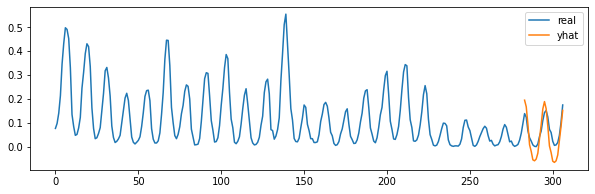

In [70]:

plot_prediction(train_data, test_data, forecast.tail(test_data.shape[0])['yhat'].values)

<h2> Neural Prophet </h2>

In [72]:
m = NeuralProphet()
metrics = m.fit(df_train, freq='M')
future = m.make_future_dataframe(df_train, periods=df_val.shape[0])
forecast = m.predict(future)

results['neural prophet'] = evaluate(val_data['y'].values, forecast['yhat1'].values)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 113
INFO:nprophet.config:Auto-set epochs to 113


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-02
INFO:nprophet:learning rate range test found optimal lr: 6.58E-02
Epoch[113/113]: 100%|██████████| 113/113 [00:06<00:00, 17.76it/s, SmoothL1Loss=0.0128, MAE=0.0456, RegLoss=0]


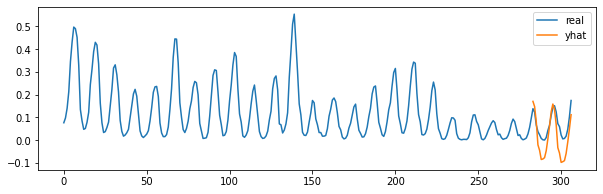

In [73]:
plot_prediction(df_train, df_val, forecast['yhat1'].values)

N-beats 

In [75]:
train_data = np.expand_dims(df_train['y'].values, axis=1)
val_data =  np.expand_dims(df_val['y'].values, axis=1)

backcast_length = 150

model = NBeats(data=train_data, period_to_forecast=24, backcast_length=backcast_length)
model.fit(epoch=2)
forecast = model.predict()

results['NBetas'] = evaluate(val_data, forecast)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=150, forecast_length=24, share_thetas=False) at @140146218884944
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=150, forecast_length=24, share_thetas=False) at @140146218882640
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=150, forecast_length=24, share_thetas=False) at @140146218883600
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=150, forecast_length=24, share_thetas=False) at @140146217422608
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=150, forecast_length=24, share_thetas=False) at @140146218116496
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=150, forecast_length=24, share_thetas=False) at @140146207132496
grad_step = 000030, tr_loss = 0.026545, te_loss = 0.232833
grad_step = 000060, tr_loss = 0.014664, te_lo

In [50]:
forcasted_train = [model.predict(train_data[i:backcast_length + i]) for i in range(train_data.shape[0] - backcast_length)]
real_train = [train_data[i:backcast_length + i] for i in range(train_data.shape[0] - backcast_length)]

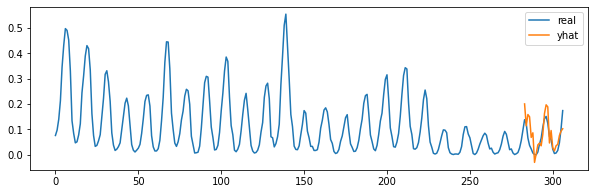

In [51]:
plot_prediction(pd.DataFrame(train_data, columns=['y']), pd.DataFrame(val_data, columns=['y']), forecast)

Classic models

tbeats

In [76]:
train_data = df_train.copy()
val_data = df_val.copy()

estimator = TBATS(seasonal_periods=[12, 5])

fitted_model = estimator.fit(train_data['y'].values)

# Forecast 24 steps ahead
forecast = fitted_model.forecast(steps=24)

print(fitted_model.summary())

results['TBATS'] = evaluate(val_data['y'].values, forecast)

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [ 5. 12.]
Seasonal harmonics [1 5]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.172384
Smoothing (Alpha): 1.295168
Trend (Beta): -0.151840
Damping Parameter (Phi): 0.871450
Seasonal Parameters (Gamma): [ 2.03387802e-07 -4.49563174e-07  1.57094037e-07 -7.06362543e-08]
AR coefficients []
MA coefficients []
Seed vector [-1.08894725 -0.07485743  0.01041749  0.02236761 -0.84854616 -0.07807191
  0.00986099 -0.01596341 -0.04077335 -0.43315689 -0.05222987 -0.03869746
 -0.03875661 -0.04092972]

AIC -725.553826


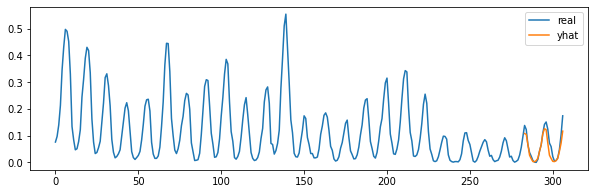

In [53]:
plot_prediction(train_data, val_data, forecast)

SARIMAX

In [78]:
train_data = df_train.copy()
train_data['y'] = np.log(train_data['y'] + 1)

val_data = df_val.copy()
val_data['y'] = np.log(val_data['y'] + 1)

mod = sm.tsa.statespace.SARIMAX(train_data['y'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit()
print(res.summary())

forecast = res.forecast(steps=24)

results['SARIMAX'] = evaluate(val_data['y'].values, forecast)

                                     SARIMAX Results                                      
Dep. Variable:                           D.DS12.y   No. Observations:                  270
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 677.978
Date:                            Wed, 28 Apr 2021   AIC                          -1347.957
Time:                                    08:10:30   BIC                          -1333.563
Sample:                                         0   HQIC                         -1342.177
                                            - 270                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5248      0.052     10.077      0.000       0.423       0.627
ar.L2         -0.0792      0.052   

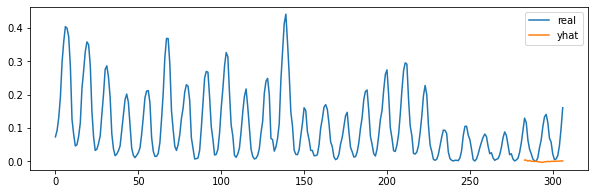

In [79]:
plot_prediction(train_data, val_data, forecast)

ETS

In [80]:
train_data = df_train.copy()
val_data = df_val.copy()

mod = SimpleExpSmoothing(train_data['y'])
res = mod.fit()
print(res.summary())

forecast = res.forecast(steps=24)

results['ETS'] = evaluate(val_data['y'].values, forecast)

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                      y   No. Observations:                  283
Model:             SimpleExpSmoothing   SSE                              0.893
Optimized:                       True   AIC                          -1625.819
Trend:                           None   BIC                          -1618.528
Seasonal:                        None   AICC                         -1625.675
Seasonal Periods:                None   Date:                 Wed, 28 Apr 2021
Box-Cox:                        False   Time:                         08:10:31
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              0.0762122                

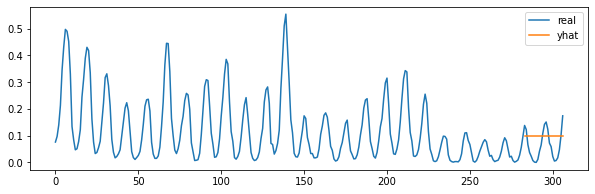

In [81]:
plot_prediction(train_data, val_data, forecast)

In [107]:
models_scores = pd.DataFrame(results).T
models_scores.style.highlight_max(subset=['r2'], axis=0, color='lightgreen').highlight_min(subset=['mae', 'mape', 'mse', 'smape'], axis=0, color='lightgreen').set_precision(2)

,mae,mse,r2,mape,smape
prophet,0.04,0.00,0.15,152.82,96.15
neural prophet,0.06,0.00,-0.64,220.22,112.46
NBetas,0.03,0.00,0.44,56.16,46.33
TBATS,0.02,0.00,0.80,22.59,31.77
SARIMAX,0.06,0.01,-1.47,71.16,139.93
ETS,0.06,0.00,-0.37,223.18,80.88
